# Position Predictor (In Progress)

`Given the position of 1,3,5 players + ball have the model try and predict the position of the other player.`

The intent of this notebook is to document the analysis of hypotheses related to the development of a position predictor model.  This analysis will be used in the construction and justification of a final model and pipeline.

In [38]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import itertools
import random
import xgboost as xgb
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.multioutput import MultiOutputRegressor

In [13]:
# CONFIGS
POSITION_COLUMNS = ['pos_x', 'pos_y', 'pos_z']
NCOLS = len(POSITION_COLUMNS)
RANDOM_SEED = 42
TEST_RATIO = 0.2
VALIDATE_RATIO = 0.2
PARTITION_RANGE = 1000
CACHE_PATH = "./.replay_cache"
RASTER_RESOLUTION = (7,7,5)
PLAY_AREA_DIMENSION = (4096, 5120, 2044)

In [14]:
random.seed(RANDOM_SEED)

## Data Exploration

Before doing anything, I need to just get a grip on what the data is and what can be done with it.

In [15]:
import data
importlib.reload(data)
data_manager = data.FileCachedCalculated()

Caching replays at: /home/axelmagn/.replays_cache


In [16]:
replays = data_manager.get_replay_list(num=10)

In [17]:
replays

['D4DE3A894229D5B8A5D0AE9091D3CA6C',
 '4DC852DA4D28F5D9047C509CA03412C8',
 'EF578C404F791CE044EFDEB0036DA5EA',
 'B828B7FD472EE7A19E9A9C8ECB7CA14B',
 'A21C39DD402315E9831EC58C7A331F64',
 '1C1AA99611E7A6E035C32F9551CD5D38',
 '7901299C11E7D3B2E06E8CB0DF9F6172',
 '997C8F1E11E7F7D384BBD0BC1A6F09FC',
 'F15A0B1211E814E30254D78BDDA89CDC',
 'B61A9AA211E829665CEB87A590E3C53A']

In [18]:
df0 = data_manager.get_pandas(replays[1])

In [19]:
df0[.head()

Hunter746                                                               \
          pos_x   pos_y pos_z     rot_x     rot_y    rot_z vel_x vel_y vel_z   
index                                                                          
0       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
1       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
2       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
3       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
4       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   

                 ...      xcuttington21                                  \
      ang_vel_x  ... double_jump_active dodge_active ping boost_collect   
index            ...                                                      
0           0.0  ...              False        False  NaN           NaN   
1           0.0  ...              False        False  NaN           NaN   
2           0.0  ...              False        False  NaN           NaN   
3           0.0  ...              False        False  NaN           NaN   
4           0.0  ...              False        False  NaN           NaN   

            game                                                           \
            time     delta seconds_remaining replicated_seconds_remaining   
index                                                                       
0      19.284970  0.004000             300.0                          NaN   
1      19.321173  0.036207             300.0                          NaN   
2      19.357170  0.036002             300.0                          NaN   
3      19.393167  0.036002             300.0                          NaN   
4      19.429302  0.036138             300.0                          NaN   

                                     
      ball_has_been_hit goal_number  
index                                
0                  None         NaN  
1                  None         NaN  
2                  None         NaN  
3                  None         NaN  
4                  None         NaN  

[5 rows x 154 columns]

In [20]:
df0.columns

MultiIndex(levels=[['Hunter746', 'Hunters Coach', 'ball', 'game', 'jjgamer345', 'madkillerDC', 'oeskrew187', 'xcuttington21'], ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'ball_cam', 'ball_has_been_hit', 'boost', 'boost_active', 'boost_collect', 'delta', 'dodge_active', 'double_jump_active', 'goal_number', 'handbrake', 'hit_team_no', 'jump_active', 'ping', 'pos_x', 'pos_y', 'pos_z', 'replicated_seconds_remaining', 'rot_x', 'rot_y', 'rot_z', 'seconds_remaining', 'steer', 'throttle', 'time', 'vel_x', 'vel_y', 'vel_z']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3]

In [21]:
df0['ball'].tail()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
index,,,,,,,,,,,,,
11145,3304,1088,157,-5.481956,-1.391006,-1.539565,-4687.0,-13167.0,-6975.0,-4736.0,-1810.0,2918.0,0.0
11146,3281,1024,123,-5.286370,-1.302130,-1.596035,-2668.0,-16516.0,-2480.0,1694.0,-53.0,1439.0,0.0
11147,3272,969,115,-5.340156,-1.279407,-1.626716,-2665.0,-16500.0,-2694.0,1694.0,-53.0,1439.0,0.0
11148,3263,914,105,-5.393559,-1.255630,-1.657204,-2662.0,-16483.0,-2908.0,1694.0,-53.0,1439.0,0.0
11149,3254,859,95,-5.446386,-1.230799,-1.687500,-2660.0,-16466.0,-3122.0,1694.0,-53.0,1439.0,0.0


In [22]:
df0['game'].head()

,time,delta,seconds_remaining,replicated_seconds_remaining,ball_has_been_hit,goal_number
index,,,,,,
0,19.284970,0.004000,300.0,NaN,None,NaN
1,19.321173,0.036207,300.0,NaN,None,NaN
2,19.357170,0.036002,300.0,NaN,None,NaN
3,19.393167,0.036002,300.0,NaN,None,NaN
4,19.429302,0.036138,300.0,NaN,None,NaN


In [40]:
df0['Hunter746'][POSITION_COLUMNS].describe()

,pos_x,pos_y,pos_z
count,11123.000000,11123.000000,11123.000000
mean,98.570350,-540.919087,73.201924
std,1842.828864,2957.910077,183.963418
min,-4079.000000,-5784.000000,16.000000
25%,-1007.000000,-3263.000000,18.000000
50%,84.000000,-596.000000,18.000000
75%,1285.500000,1770.000000,20.000000
max,4079.000000,5888.000000,2007.000000


In [24]:
df0['Hunter746'].columns

Index(['pos_x', 'pos_y', 'pos_z', 'rot_x', 'rot_y', 'rot_z', 'vel_x', 'vel_y',
       'vel_z', 'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'throttle', 'steer',
       'handbrake', 'ball_cam', 'jump_active', 'double_jump_active', 'boost',
       'boost_active', 'dodge_active', 'ping', 'boost_collect'],
      dtype='object')

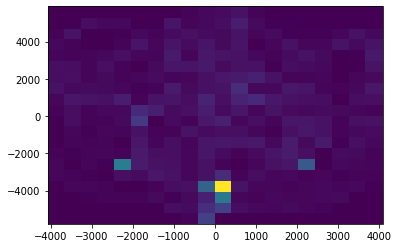

In [25]:
p0_xy = df0['Hunter746'][["pos_x", "pos_y"]].dropna()
x = p0_xy['pos_x']
y = p0_xy['pos_y']
plt.hist2d(x,y, bins=20)
plt.show()

In [26]:
proto0 = data_manager.get_proto(replays[1])

In [27]:
# (verbose)
proto0.game_metadata.team_size

3

## Data Retrieval (TODO)

This stage retrieves replays from the internet, and caches them locally.


### Train / Validation / Test Split (TODO)

Data partitioning should be done on a per-replay basis, so that there are no chances for the model to memorize similar frames from the same replay.

In [28]:
class Replay(object):
    def __init__(self, df, proto):
        self.df = df
        self.proto = proto

def get_replay(replay_id, manager):
    df = manager.get_pandas(replay_id)
    proto = manager.get_proto(replay_id)
    if df is None or proto is None:
        return None
    return Replay(df, proto)

def partition_replays(replay_list):
    return (
        list(filter(_is_train_partition, replay_list)),
        list(filter(_is_validate_partition, replay_list)),
        list(filter(_is_test_partition, replay_list)),
    )

_TRAIN_PARTITION = (1 - TEST_RATIO - VALIDATE_RATIO) * PARTITION_RANGE
_TEST_PARTITION = (1 - TEST_RATIO) * PARTITION_RANGE

def _is_train_partition(replay_id):
    id_value = abs(hash(replay_id)) % PARTITION_RANGE
    return id_value < _TRAIN_PARTITION

def _is_validate_partition(replay_id):
    id_value = abs(hash(replay_id)) % PARTITION_RANGE
    return id_value >= _TRAIN_PARTITION and id_value < _TEST_PARTITION

def _is_test_partition(replay_id):
    id_value = abs(hash(replay_id)) % PARTITION_RANGE
    return id_value >= _TEST_PARTITION

In [29]:
# for now, we will just do a manual split of the first 10 replays
replays = data_manager.get_replay_list(num=50)
train_replays, validate_replays, test_replays = partition_replays(replays)

In [30]:
len(train_replays), len(validate_replays), len(test_replays)

(31, 13, 6)

## Preprocessing

This stage takes replay dataframes and protobufs and prepares them as a numpy matrix suitable for model ingestion and analysis. There are 2 possible schemas I want to explore for state representation. 


### Schema: analog positions (DONE)

Records shall be represented as position vectors as shown below

```
<ball> <t0_p0> <t0_p1> <t0_p2> <t1_p0> <t1_p1> <t1_p2>
foreach: <pos_x> <pos_y> <pos_z>
```

### Schema: rasterized positions (TODO)

Records shall be represented as 3-channel rasterized images, with a channel each for ball, team_0, and team_1.   This can be generated from the condensed positions.

### Filtering (TODO)

Starting positions are likely to be over-represented in this dataset.  It may be useful to filter out all frames before a ball has been hit.

### Reordering (TODO)

The data could then be expanded to capture the symmetries of team and player reordering.  Player ordering in the condensed schema is arbitrary, and each record could generate `3! * 3! = 36` permutations. Team ordering is not arbitrary, but teams could be swapped by negating `pos_y` values.  This would increase the total available permutations to `36 * 2 = 72`.  There is also x-axis symmetry, so by negating X values we get another mirror, bringing it to `72 * 2 = 144` permutations.

### Distortion (TODO)

Optionally, it would be possible to slightly randomize positions, in order to help generalize.


### Dropout (TODO)

The original plan was to omit one player, and make the predictor guess it. If we are already have generated all reorderings, it should be sufficient to simply omit the final player.  However, I would also like to explore the possibility of a GAN or Autoencoder where one position within a valid record is fabricated, and the predictor must reconstruct the valid position from the invalid one.

In [31]:
def analog_positions(replay):
    assert replay is not None
    proto = replay.proto
    dataframe = replay.df
    assert proto is not None
    assert dataframe is not None
    ball_posn = get_named_posn(dataframe, 'ball')
    ball_posn = add_col_prefix(ball_posn, "ball_")
    t0_posns = []
    t1_posns = []
    for player in proto.players:
        posn = get_named_posn(dataframe, player.name)
        if player.is_orange == 0:
            t0_posns.append(posn)
        else:
            t1_posns.append(posn)
    for i, posn in enumerate(t0_posns):
        t0_posns[i] = add_col_prefix(posn, 't0_p{}_'.format(i))
    for i, posn in enumerate(t1_posns):
        t1_posns[i] = add_col_prefix(posn, 't1_p{}_'.format(i))
    positions = [ball_posn] + t0_posns + t1_posns
    return pd.concat(positions, axis=1).dropna()

def get_named_posn(dataframe, name):
    return dataframe[name][POSITION_COLUMNS]

def get_named_player(proto, player_name):
    for player in proto.players:
        if player.name == player_name:
            return player
    raise ValueError("Could not find player: " + player_name)
    
def add_col_prefix(dataframe, prefix):
    return dataframe.rename(lambda col: prefix + col, axis='columns')

In [32]:
loaded_replays = filter(lambda r: r is not None, (get_replay(replay_name, data_manager) for replay_name in train_replays))
train_aps = pd.concat((analog_positions(r) for r in loaded_replays), axis=0)

E0601 17:37:23.077068 140133728540288 pandas_manager.py:29] Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/

In [33]:
loaded_replays = filter(lambda r: r is not None, (get_replay(replay_name, data_manager) for replay_name in validate_replays))
validate_aps = pd.concat((analog_positions(r) for r in loaded_replays), axis=0)

E0601 17:37:54.051023 140133728540288 pandas_manager.py:29] Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/axelmagn/workspace/personal/ReplayModels/venv/lib/

In [34]:
# Split features and targets
def get_analog_features(analog_positions_dataframe):
    return np.copy(analog_positions_dataframe.values[:,:-NCOLS])

def get_analog_targets(analog_positions_dataframe):
    return np.copy(analog_positions_dataframe.values[:,-NCOLS:])

# TODO: split train, validation, and test sets based on multiple replays

In [35]:
train_aps_features = get_analog_features(train_aps)
train_aps_targets = get_analog_targets(train_aps)
validate_aps_features = get_analog_features(validate_aps)
validate_aps_targets = get_analog_targets(validate_aps)

In [ ]:
# rasterization


## Model Selection

This stage evaluates different models on the training data.  Below is a list of model hypotheses that should be considered.

### Models

#### XGBoost (Baseline) (In Progress)

XGBoost performs well at many complex regression problems, and is easy to apply using a library.  It will serve as the baseline against which more sophisticated model hypotheses can be compared.

#### Clustering / KNN (Baseline) (TODO)

Another simple solution would be to retrieve similar memorized positions.

#### Deep Neural Networks (TODO)

After baselines have been measured, more sophisticated models such as convolutional neural networks can be considered.

### Selection Criteria

As important as the models is our criteria for evaluating them.  Since this problem does not easily map to a real-world loss function, this can be somewhat arbitrary, and may depend on the output schema.

#### RMSE (Single Output Schema)

Old reliable.

#### MAE (Single Output Schema)

It may be justifiable to use this since I don't care too much about missing outliers.

#### R^2 (Single Output Schema)

SKLearn default.  Seems to have some advantages.  Will probably stick with this out of convenience.

#### Probability Weighted Score (Distribution Output Schema)

If the model outputs a probability distribution across multiple possible positions, I think it makes sense to add up the score of those positions, multiplied by their predicted probability weight.



## XGBoost

Try training with XGBoost.  Key questions:

1. would we benefit from more training data?
2. would we benefit from more iterations?
3. Are the hyperparameters optimaly tuned?

In [25]:
def xgb_model(**kwargs):
    return MultiOutputRegressor(xgb.XGBRegressor(learning_rate=0.01, objective='reg:squarederror', random_seed=0))

In [29]:
model = xgb_model()
model.fit(train_features, train_targets)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.01,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=1, missing=None,
                                            n_estimators=100, n_jobs=1,
                                            nthread=None,
                                            objective='reg:squarederror',
                                            random_seed=0, random_state=0,
                                            reg_alpha=0, reg_lambda=1,
                                            scale_pos_weight=1, seed=None,
          

In [31]:
# how does this model perform out of the box?
model.score(validate_features, validate_targets)

0.23961912393954052

In [32]:
# TODO: give a shit about the other questions

## Simple Dense Classifier

## TMP: Tensorflow sanity check

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11493376/11490434 [==============================] - 3s 0us/step


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [4]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [7]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [8]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [11]:

EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))


Epoch 1, Loss: 0.1341739147901535, Accuracy: 95.8933334350586, Test Loss: 0.05695280432701111, Test Accuracy: 98.08999633789062
Epoch 2, Loss: 0.0873652845621109, Accuracy: 97.33583068847656, Test Loss: 0.05193914473056793, Test Accuracy: 98.22000122070312
Epoch 3, Loss: 0.06430377066135406, Accuracy: 98.03722381591797, Test Loss: 0.05261257290840149, Test Accuracy: 98.26333618164062
Epoch 4, Loss: 0.05145478621125221, Accuracy: 98.4254150390625, Test Loss: 0.053377918899059296, Test Accuracy: 98.32250213623047
Epoch 5, Loss: 0.042890507727861404, Accuracy: 98.68299865722656, Test Loss: 0.054339755326509476, Test Accuracy: 98.35399627685547


In [10]:
tf.test.is_gpu_available()

False